# Check my outfit

### **INPUT:** user's decision 
chosen colors for: top, bottom and shoes
### **OUTPUT:** match or not

The goal is to successfully match 3 colors in a way that is considered 'MATCHING'
There are several guides to match three colors of a basic outfit consisting of:
<br>
- TOP(top) - shirt or blouse
- BOTTOM(bot) - pants or shorts
- SHOES(shs) - shoes

We asume all 3 pieces of clothing are plain and do not contain complex color or designs

### This are all the functions we need to run the code. please scroll down to the interactive section - search "Interactive section starts here"

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import colorsys
import warnings

warnings.filterwarnings('ignore')

In [2]:
class color: #for fonts
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

## Fuzzy logic models

In [3]:
"""
Antecedents HSV
HUE: color represented by number from 0(red) - 360(violet)
{ WARM, COOL }

SATURATION: color saturation represented by number from 0(faded/gray color) - 100(full color)
{ GRAY, VERY_FADED, FADED, SATURATED, VERY_SATURATED }

VALUE: brightness represented by number 0(dark) - 100(light)
{ BLACK, VERY_DARK, DARK, BRIGHT, VERY_BRIGHT }
"""

hue_range = np.arange(0, 361, 1)
hue_fuzzy = ['WARM', 'COOL', 'WARM_']
hue = ctrl.Antecedent(hue_range, 'hue')
hue['WARM'] = fuzz.gaussmf(hue.universe, 0, 60)
hue['COOL'] = fuzz.gaussmf(hue.universe, 180, 60)
hue['WARM_'] = fuzz.gaussmf(hue.universe, 360, 60)


sat = ctrl.Antecedent(np.arange(0, 101, 1), 'saturation')
sat_fuzzy = ['GRAY', 'VERY_FADED', 'FADED', 'SATURATED', 'VERY_SATURATED']
sat['GRAY'] = fuzz.gaussmf(sat.universe, 0, 10)
sat['VERY_FADED'] = fuzz.gaussmf(sat.universe, 25, 10)
sat['FADED'] = fuzz.gaussmf(sat.universe, 50, 10)
sat['SATURATED'] = fuzz.gaussmf(sat.universe, 75, 10)
sat['VERY_SATURATED'] = fuzz.gaussmf(sat.universe, 100, 10)


val = ctrl.Antecedent(np.arange(0, 101, 1), 'value')
val_fuzzy = ['BLACK', 'VERY_DARK', 'DARK', 'BRIGHT', 'VERY_BRIGHT']
val['BLACK'] = fuzz.gaussmf(val.universe, 0, 10)
val['VERY_DARK'] = fuzz.gaussmf(val.universe, 25, 10)
val['DARK'] = fuzz.gaussmf(val.universe, 50, 10)
val['BRIGHT'] = fuzz.gaussmf(val.universe, 75, 10)
val['VERY_BRIGHT'] = fuzz.gaussmf(val.universe, 100, 10)

In [4]:
"""
Consequents
TONE: mix of Saturation and Value that indicate if color is neutral or dark/bright
{ NEUTRAL, DARK, BRIGHT }
"""
tone_range = np.arange(0, 12, 1)
tone_fuzzy = ['NEUTRAL', 'DARK', 'BRIGHT']
tone = ctrl.Consequent(tone_range, 'tone')

tone['NEUTRAL'] = fuzz.trapmf(tone.universe, [0, 0, 1, 2])
tone['DARK'] = fuzz.gbellmf(tone.universe, 2, 1, 3)
tone['BRIGHT'] = fuzz.gbellmf(tone.universe, 4, 1, 9.5)
#tone['NEUTRAL_'] = fuzz.trimf(tone.universe, [10, 11, 11])

In [5]:
"""
Fuzzy rules
for tones
"""
rule1 = ctrl.Rule(val['BLACK'] | sat['GRAY'] | sat['VERY_FADED'], tone['NEUTRAL'], 'Dark colors without color (low brightness/dark) considered neutral')
rule2 = ctrl.Rule(val['VERY_DARK'] & sat['SATURATED'], tone['NEUTRAL'], 'Very dark colors with high saturation')
rule3 = ctrl.Rule(val['DARK'] & sat['FADED'], tone['DARK'], 'Dark color with normal saturation')
rule4 = ctrl.Rule(val['DARK'] & sat['VERY_SATURATED'], tone['BRIGHT'], 'Dark color with high saturation')
rule5 = ctrl.Rule(val['BRIGHT'] & sat['SATURATED'], tone['BRIGHT'], 'Bright color with high saturation')
rule6 = ctrl.Rule(val['VERY_BRIGHT'] & sat['FADED'], tone['BRIGHT'], 'Very bright color with some saturation')
rule7 = ctrl.Rule(val['VERY_BRIGHT'] & sat['VERY_SATURATED'], tone['BRIGHT'], 'Very bright color with high saturation')
rule8 = ctrl.Rule(val['VERY_DARK'] & sat['FADED'], tone['NEUTRAL'], 'Very dark color with faded saturation')

In [6]:
"""
Control system
for tones
"""
tone_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6, rule7, rule8])


In [7]:
"""
Simulation
for tones
"""
tone_sim = ctrl.ControlSystemSimulation(tone_ctrl)

In [8]:
def cr_tup(my_str):
    # create tuple
    import re
    
    my_top_list = [my_str]

    for i in my_top_list:
        my_string = i.value
        values = re.findall(r'\d+', my_string)
        return tuple(map(int, values))

In [9]:
"""
GetMembership
Returns String representing the Fuzzy value given a variable's range, model, and crisp value
"""
def GetMembership(fuzzy_values, var_range, var_model, crisp_value):
    max_membership = 0
    membership_name = fuzzy_values[0]
    for i in range(len(fuzzy_values)):
        temp_memb = fuzz.interp_membership(var_range, var_model[fuzzy_values[i]].mf, crisp_value)
        if temp_memb > max_membership:
            max_membership = temp_memb
            membership_name = fuzzy_values[i]
    return membership_name


### API

In [10]:
"""
Given Saturation and Value, returns a String indicating if the combination 
of both values results in a 'NEUTRAL', 'DARK', or 'BRIGHT' tone.
INPUT:
values - tuple(sat, val)
    + sat - value from 0-100
    + val - value from 0-100
verbose - prints both crisp value and fuzzy value
"""
def GetTone(values, verbose=False):
    tone_sim = ctrl.ControlSystemSimulation(tone_ctrl)
    tone_sim.input['saturation'] = values[0]
    tone_sim.input['value'] = values[1]
    tone_sim.compute()
    tone_output = tone_sim.output['tone']
    tone_membership = GetMembership(tone_fuzzy, tone_range, tone, tone_output)
    if verbose:
        print("TONE CRISP VALUE: ", tone_output)
        print("TONE FUZZY VALUE: ", tone_membership)
    return tone_membership

In [11]:
"""
Given Hue, returns a String indicating if the color belongs
to 'WARM' or 'COOL' colors.
INPUT:
hue - value from 0-360
verbose - prints both crisp value and fuzzy value
"""
def GetColorTemp(hue_val, verbose=False):
    temp_membership = GetMembership(hue_fuzzy, hue_range, hue, hue_val)
    if verbose:
        print("TEMP. CRISP VALUE: ", hue_val)
        print("TEMP. FUZZY VALUE: ", temp_membership)
    return temp_membership

In [12]:
"""
Given Hue, Saturation, and Value, returns a String describing
the specified color. The output is composed of both the tone of
the color, and the temperature of the color.
INPUT:
hsv - tuple(hue, sat, val)
    + hue - value from 0-360
    + sat - value from 0-100
    + val - value from 0-100
OUTPUT: (TONE, TEMP) ex. (DARK, WARM)
"""
def GetColorDesc(hsv):
    tone = GetTone((hsv[1], hsv[2]))
    temp = GetColorTemp(hsv[0])
    if temp == "WARM_": temp = "WARM"
    return (tone, temp)

In [13]:
"""
Helper function that displays a colored block given a color
represented in HSV format
INPUT:
hsv - tuple(hue, sat, val)
"""
def ShowColor(hsv):
    rgb = colorsys.hsv_to_rgb(hsv[0]/360.0, hsv[1]/100.0, hsv[2]/100.0)
    fig, ax = plt.subplots(nrows=1, ncols=1)
    fig.set_size_inches(3, 2)
    ax.set_facecolor(rgb)
    plt.tick_params(
        left=False,
        bottom=False,
        labelleft=False,
        labelbottom=False)
    plt.title('HSV'+str(hsv))
    plt.show()

In [14]:
"""
Given Hue, Saturation, and Value, displays a block with the specified HSV color
and prints its color description
INPUT:
hsv - tuple(hue, sat, val)
    + hue - value from 0-360
    + sat - value from 0-100
    + val - value from 0-100
"""
def ShowColorWithDesc(hsv):
    ShowColor(hsv)
    print(GetColorDesc(hsv))

In [15]:
"""
Print colors of a complete outfit in a horizontal bar chart
INPUT:
outfit - tuple(top, bot, shs)
    + top - hsv
    + bot - hsv
    + shs - hsv
"""
def DisplayOutfitColors(outfit, valid_matches=[]):
    colors = [colorsys.hsv_to_rgb(hsv[0]/360.0, hsv[1]/100.0, hsv[2]/100.0) for hsv in outfit]

    plt.rcdefaults()
    fig, ax = plt.subplots()

    clothing = ('TOP', 'BOTTOM', 'SHOES')
    y_pos = np.arange(len(clothing))
    bar_width = [1, 1, 1]

    ax.barh(y_pos, bar_width, align='center', color=colors, height=0.99)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(clothing)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_title('Outfit color scheme')
    ax.set_facecolor((0.8,0.8,0.8))

    plt.tick_params(
            left=True,
            bottom=False,
            labelleft=True,
            labelbottom=False)
    plt.margins(y=0, x=0)

    plt.show()
    
    print("Valid outfit color schemes: ", valid_matches)

# Testing - Check My Outfit

### Basic outfit

In [16]:
"""
Basic outfit follow these rules
- No more than one bright color
- No high contrast between colors (bright warm + dark cool)
- Any number of neutral colors can fit anywhere
INPUT:
outfit - tuple(top, bot, shs)
    top - tuple(tone, temp)
    bot - tuple(tone, temp)
    shs - tuple(tone, temp)
OUTPUT: 
    True or False
"""
def BasicMatch(outfit):
    top = outfit[0]
    bot = outfit[1] 
    shs = outfit[2]
    
    bright_count = len([i for i in outfit if i[0] == 'BRIGHT'])
    if bright_count > 1: return False
    # Check for high contrast
    
    return True

### Neutral outfit

In [17]:
"""
Neutral outfit follow these rules
- Only neutral colors
INPUT:
outfit - tuple(top, bot, shs)
    top - tuple(tone, temp)
    bot - tuple(tone, temp)
    shs - tuple(tone, temp)
OUTPUT:
    True or False
"""
def NeutralMatch(outfit):
    top = outfit[0]
    bot = outfit[1] 
    shs = outfit[2]
    
    neutral = [color for color in outfit if color[0] == 'NEUTRAL']
    if len(neutral) != len(outfit):
        return False
    
    return True

### Analogous outfit

In [18]:
"""
Analogous outfit follow these rules
- All colors must be within the same temp.
- Any number of neutral colors
INPUT:
outfit - tuple(top, bot, shs)
    top - tuple(tone, temp)
    bot - tuple(tone, temp)
    shs - tuple(tone, temp)
OUTPUT:
    True or False
"""
def AnalogousMatch(outfit):
    top = outfit[0]
    bot = outfit[1] 
    shs = outfit[2]
    
    cool_count = len([color for color in outfit if color[1] == 'COOL'])
    warm_count = len(outfit) - cool_count
    if cool_count < len(outfit) and warm_count < len(outfit):
        return False
    
    return True

### Contrast outfit

In [19]:
"""
Contrast outfit follow these rules
- At least one warm color
- Both dark and bright colors present
INPUT:
outfit - tuple(top, bot, shs)
    top - tuple(tone, temp)
    bot - tuple(tone, temp)
    shs - tuple(tone, temp)
OUTPUT:
    True or False
"""
def ContrastMatch(outfit):
    top = outfit[0]
    bot = outfit[1] 
    shs = outfit[2]
    
    warm_count = len([color for color in outfit if color[1] == 'WARM'])
    if warm_count < 1: return False
    
    dark_count = len([color for color in outfit if color[0] == 'DARK'])
    bright_count = len([color for color in outfit if color[0] == 'BRIGHT'])
    if dark_count < 1 or bright_count < 1:
        return False
    
    return True

### Bright summer outfit

In [20]:
"""
Bright summer outfit follow these rules
- At least two warm colors
- At least one bright color
- At most one dark color
INPUT:
outfit - tuple(top, bot, shs)
    top - tuple(tone, temp)
    bot - tuple(tone, temp)
    shs - tuple(tone, temp)
OUTPUT: 
    True or False
"""
def SummerMatch(outfit):
    top = outfit[0]
    bot = outfit[1] 
    shs = outfit[2]
    
    non_neutral = [color for color in outfit if color[0] != 'NEUTRAL']
    
    warm_count = len([color for color in non_neutral if color[1] == 'WARM'])
    if warm_count < 2: return False
    
    dark_count = len([color for color in non_neutral if color[0] == 'DARK'])
    if dark_count > 1: return False
    
    bright_count = len(non_neutral) - dark_count
    if bright_count < 1: return False
    
    return True

### Dark winter outfit

In [21]:
"""
Dark winter outfit follow these rules
- At least one dark color
- No bright colors
INPUT:
outfit - tuple(top, bot, shs)
    top - tuple(tone, temp)
    bot - tuple(tone, temp)
    shs - tuple(tone, temp)
OUTPUT:
    True or False
"""
def WinterMatch(outfit):
    top = outfit[0]
    bot = outfit[1] 
    shs = outfit[2]
    
    non_neutral = [color for color in outfit if color[0] != 'NEUTRAL']
    
    dark_count = len([color for color in non_neutral if color[0] == 'DARK'])
    if dark_count < 1: return False
    
    bright_count = len(non_neutral) - dark_count
    if bright_count > 0: return False
    
    return True

In [22]:
"""
Iterate outfit over all color schemes and get all valid matches
INPUT:
outfit - tuple(top, bot, shs)
    top - hsv
    bot - hsv
    shs - hsv
OUTPUT:
    All names of valid outfit matches
"""
def GetValidMatches(outfit):
    top = GetColorDesc(outfit[0])
    bot = GetColorDesc(outfit[1])
    shs = GetColorDesc(outfit[2])
    outfit_desc = (top, bot, shs)
    
    rules = {"Basic": BasicMatch, "Neutral": NeutralMatch,
             "Analogous": AnalogousMatch, "Summer": SummerMatch,
            "Winter": WinterMatch}
    valid_matches = []
    for key in rules:
        if rules[key](outfit_desc):
            valid_matches.append(key)
    if valid_matches: # if there is a match
        print(color.BOLD + "It's a match!" + color.END)
    else:
        print(color.BOLD + "It doesn't match!" + color.END)
    return valid_matches

In [23]:
from ipywidgets import widgets
# Print that the HSV value are inserted - the HSV input should be in ( , , ) format
# def on_submit(b, top, bottom, shoes):
#     print("Your HSV values were inserted to the system")
#     input_outfit = ((cr_tup(top),cr_tup(bottom),cr_tup(shoes)))
    
def on_submit(top, bottom, shoes):
    input_outfit = ((cr_tup(top),cr_tup(bottom),cr_tup(shoes)))
    outfit_hsv=(top, bottom, shoes)
    DisplayOutfitColors(input_outfit, valid_matches=GetValidMatches(input_outfit))

#     DisplayOutfitColors((cr_tup(top), cr_tup(bottom),cr_tup(shoes)))
#     GetValidMatches(input_outfit)
    topDESC = GetColorDesc(cr_tup(top))
    botDESC = GetColorDesc(cr_tup(bottom))
    shsDESC = GetColorDesc(cr_tup(shoes))
    outfit_desc = (topDESC, botDESC, shsDESC)
    print(outfit_desc)

def displayButton():
    print("Insert HSV values in (H,S,V) format (including the '()')")
# Create text input widgets for getting HSV value
    hsv_top = widgets.Text(value='', placeholder='HSV TOP')
    hsv_bottom = widgets.Text(value='', placeholder='HSV BOTTOM')
    hsv_shoes = widgets.Text(value='', placeholder='HSV SHOES')

    # Display the input widgets
    display(widgets.HTML("<b>Top</b>"))
    display(hsv_top)

    display(widgets.HTML("<b>Bottom</b>"))
    display(hsv_bottom)

    display(widgets.HTML("<b>Shoes</b>"))
    display(hsv_shoes)
    # Create a submit button
#     submit_button = widgets.Button(description="Submit")
#     submit_button.on_click(on_submit, top = hsv_top, bottom = hsv_bottom, shoes=hsv_shoes)
    
    submit_button = widgets.Button(description="Submit")
    submit_button.on_click(lambda b: on_submit(hsv_top, hsv_bottom,hsv_shoes))
    # Display the submit button
    display(submit_button)

## Interactive section starts here
### please click on the below cell and run all the above. Then you can start running the below cell

Insert HSV values in (H,S,V) format (including the '()')


HTML(value='<b>Top</b>')

Text(value='', placeholder='HSV TOP')

HTML(value='<b>Bottom</b>')

Text(value='', placeholder='HSV BOTTOM')

HTML(value='<b>Shoes</b>')

Text(value='', placeholder='HSV SHOES')

Button(description='Submit', style=ButtonStyle())

It's a match!


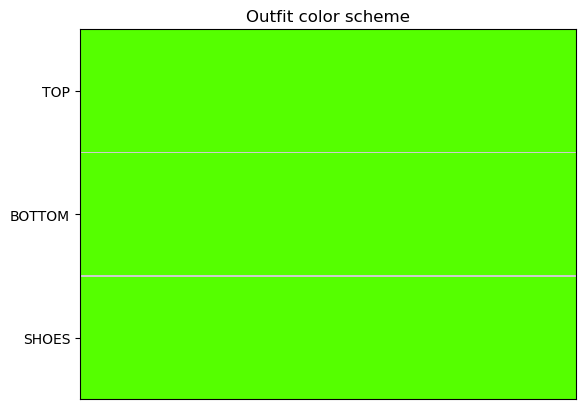

Valid outfit color schemes:  ['Analogous']
(('BRIGHT', 'COOL'), ('BRIGHT', 'COOL'), ('BRIGHT', 'COOL'))


In [24]:
displayButton()

_____________________________________________________________________________________________________________

# Expert advice

In [25]:
def convert_rgb_to_hsv(red,green,blue):
    #rgb normal: range (0-255, 0-255, 0.255)
    #get rgb percentage: range (0-1, 0-1, 0-1 )
    red_percentage= red / float(255)
    green_percentage= green/ float(255)
    blue_percentage=blue / float(255)
    
    #get hsv percentage: range (0-1, 0-1, 0-1)
    color_hsv_percentage=colorsys.rgb_to_hsv(red_percentage, green_percentage, blue_percentage) 
    
    #get normal hsv: range (0-360, 0-255, 0-255)
    color_h=round(360*color_hsv_percentage[0])
    color_s=round(255*color_hsv_percentage[1])
    color_v=round(255*color_hsv_percentage[2])
    color_hsv=(color_h, color_s, color_h)
    return color_hsv

In [26]:
my_top = convert_rgb_to_hsv(250,242,240)
my_bottom = convert_rgb_to_hsv(158,133,140)
my_shoes = convert_rgb_to_hsv(0,0,0)

my_outfit = (my_top,my_bottom,my_shoes)

In [27]:
GetValidMatches(my_outfit)

It's a match!


['Basic', 'Analogous']